# Aprendizaje con pocos datos y sesgos en la generalización de modelos faciales

**Proyecto:** Evaluación de generalización y equidad de modelos faciales cuando se adaptan con subconjuntos limitados y desbalanceados de FairFace.

**Autor:** Saúl de los Reyes Pérez-Cejuela  

**Objetivos breves**
- Evaluar cómo un modelo preentrenado generaliza al adaptarse con subconjuntos limitados y desbalanceados de FairFace.
- Comparar con estrategias few-shot y con data augmentation para balancear clases.
- Medir rendimiento global y métricas de equidad (demographic parity, equalized odds, per-group metrics).
- Analizar la influencia del tamaño y balance del dataset sobre el sesgo del modelo.
- Reflexionar sobre implicaciones éticas de entrenar con datos limitados o sesgados.


## 1. Introducción y contexto

El reconocimiento y la clasificación facial pueden verse fuertemente afectados por la **distribución de los datos** y por la **representatividad** de las clases. En este proyecto trabajaremos con FairFace (dataset con anotaciones raciales, género y edad) para explorar cómo distintas **configuraciones de muestreo** (tamaños y balanceos) afectan el rendimiento y la equidad de modelos preentrenados.

**Preguntas de investigación**
- ¿Cómo varía la precisión general y por grupo al reducir el tamaño del conjunto de adaptación?
- ¿Cuánto ayuda el balance mediante augmentations a mitigar brechas entre grupos?
- ¿Qué diferencias emergen entre fine-tuning completo y estrategias few-shot (p. ej. linear-probe / adapters) cuando los datos son escasos?


## 2. Hipótesis

1. Los modelos adaptados con subconjuntos pequeños y desbalanceados mostrarán mayor *gap* de equidad entre grupos (p. ej. mayor diferencia en TPR entre grupos).
2. El aumento del tamaño del conjunto de adaptación reducirá la varianza y la brecha de equidad, aunque con rendimientos decrecientes después de cierto umbral.
3. El balance mediante data augmentation mejorará métricas globales y reducirá parcialmente las brechas, pero puede introducir artefactos si las augmentations no añaden verdadera diversidad.
4. Estrategias few-shot (linear probe, adapters) serán más robustas que el fine-tune completo en escenarios con muy pocas imágenes por clase.


## 3. Requisitos y recursos

- Entorno: Google Colab (preferible GPU: Tesla T4 / A100 si disponible).
- Librerías: PyTorch, torchvision, timm, datasets (HuggingFace), fairlearn, albumentations (opcional), scikit-learn, pandas, matplotlib, seaborn.
- Dataset principal: FairFace (descarga desde HuggingFace o repo oficial).
- Repositorios y tracking (opcional): W&B, MLflow o guardar checkpoints en Google Drive.


In [5]:
import os
import sys
import random
import copy
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print("Device capability:", torch.cuda.get_device_properties(0))
else:
    print("No GPU disponible — el entrenamiento será lento.")


Python: 3.11.0
Torch: 2.5.1+cu121
CUDA available: True
Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Device capability: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Ti Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=20, uuid=ed9d96b4-9507-7d59-206a-2a2df79a6356, L2_cache_size=2MB)


In [6]:
# Fija semillas para reproducibilidad (hasta donde sea posible)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # configuraciones para reproducibilidad en PyTorch (puede afectar rendimiento)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)
print("Semilla fijada a", SEED)


Semilla fijada a 42


## 4. Carga del dataset FairFace

El dataset **FairFace** contiene más de 100 000 imágenes de rostros humanos con anotaciones de:
- `race` (7 grupos raciales)
- `gender` (male / female)
- `age` (rangos de edad)

Vamos a usar el dataset **público oficial**, que se puede descargar directamente desde el repositorio de FairFace en GitHub.  
Descargaremos las etiquetas (`csv`) y un subconjunto reducido de imágenes (para no saturar el entorno de Colab).


In [7]:
from datasets import load_dataset
import pandas as pd

# Descargar y cargar FairFace
dataset = load_dataset("HuggingFaceM4/FairFace", "0.25") #Usamos la version reducida del dataset

# Verifica las divisiones disponibles
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


In [8]:
# Convertimos a DataFrame para explorar más fácilmente
df = pd.DataFrame(dataset["train"])

# Dividir 80% train, 20% test, estratificando por race y gender
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[['race', 'gender']]  # asegura proporciones similares
)

print(f"Tamaño train: {len(df_train)}")
print(f"Tamaño test: {len(df_test)}")



Tamaño train: 69395
Tamaño test: 17349


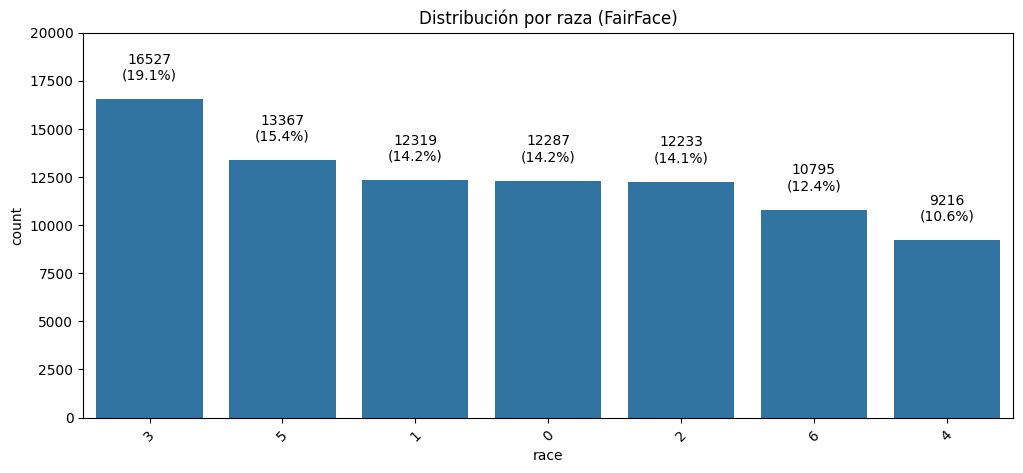

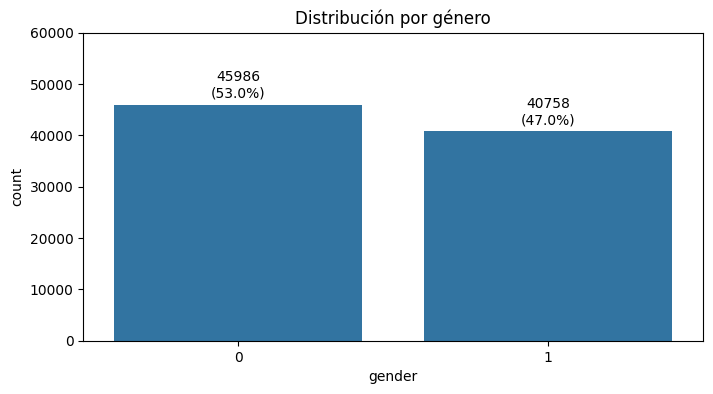

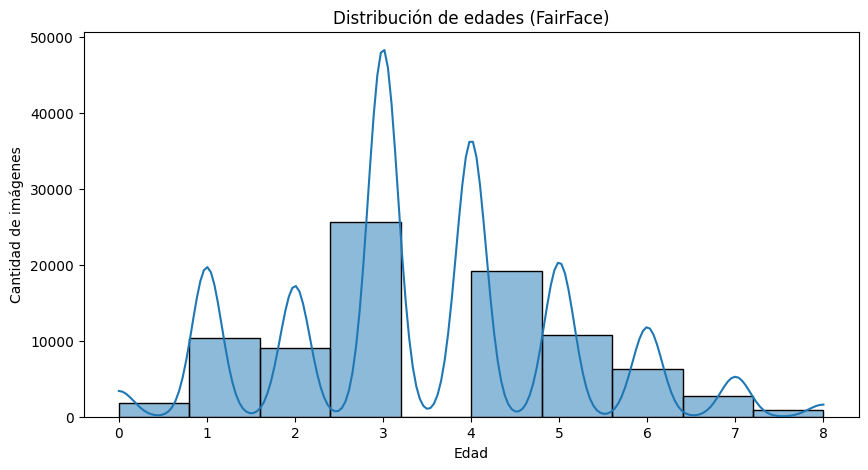

c:\Users\saulr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\saulr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\saulr\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\saulr\AppData\Local\Programs\Python\Python311

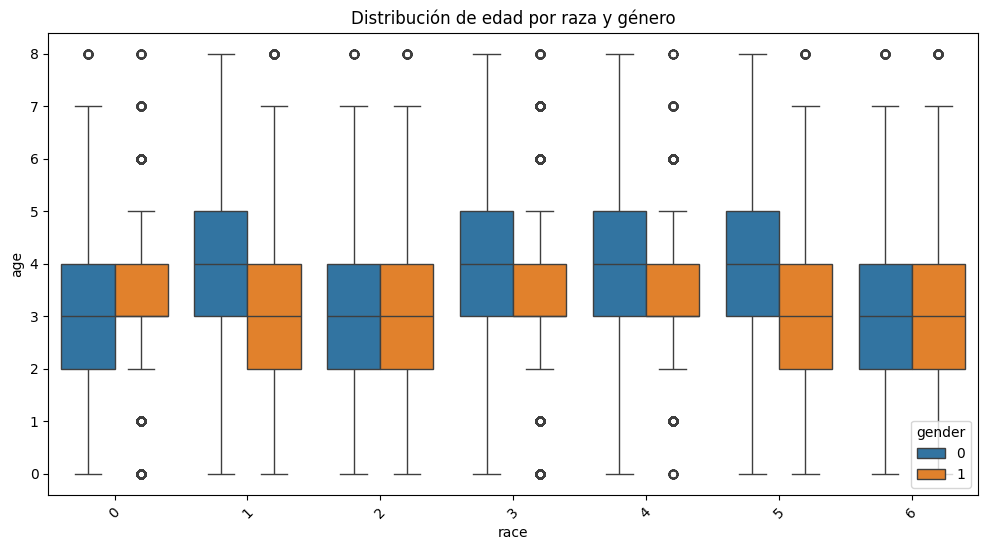

In [9]:
def annotate_countplot(ax):
    """
    Añade número absoluto y porcentaje encima de cada barra en un countplot.
    """
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
        height = int(p.get_height())
        pct = height / total * 100
        ax.annotate(f'{height}\n({pct:.1f}%)', 
                    (p.get_x() + p.get_width()/2., p.get_height() + total*0.01),  # espacio arriba relativo
                    ha='center', va='bottom', fontsize=10)

# Distribución por raza
plt.figure(figsize=(12,5))
ax = sns.countplot(data=df, x='race', order=df['race'].value_counts().index)
plt.title("Distribución por raza (FairFace)")
plt.xticks(rotation=45)
annotate_countplot(ax)
plt.ylim([0,20000])
plt.show()

# Distribución por género
plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x='gender')
plt.title("Distribución por género")
annotate_countplot(ax)
plt.ylim([0,60000])
plt.show()

# Histograma de edad
plt.figure(figsize=(10,5))
sns.histplot(df['age'], bins=10, kde=True)
plt.title("Distribución de edades (FairFace)")
plt.xlabel("Edad")
plt.ylabel("Cantidad de imágenes")
plt.show()

# Boxplot de edad por raza y género
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='race', y='age', hue='gender')
plt.title("Distribución de edad por raza y género")
plt.xticks(rotation=45)
plt.show()


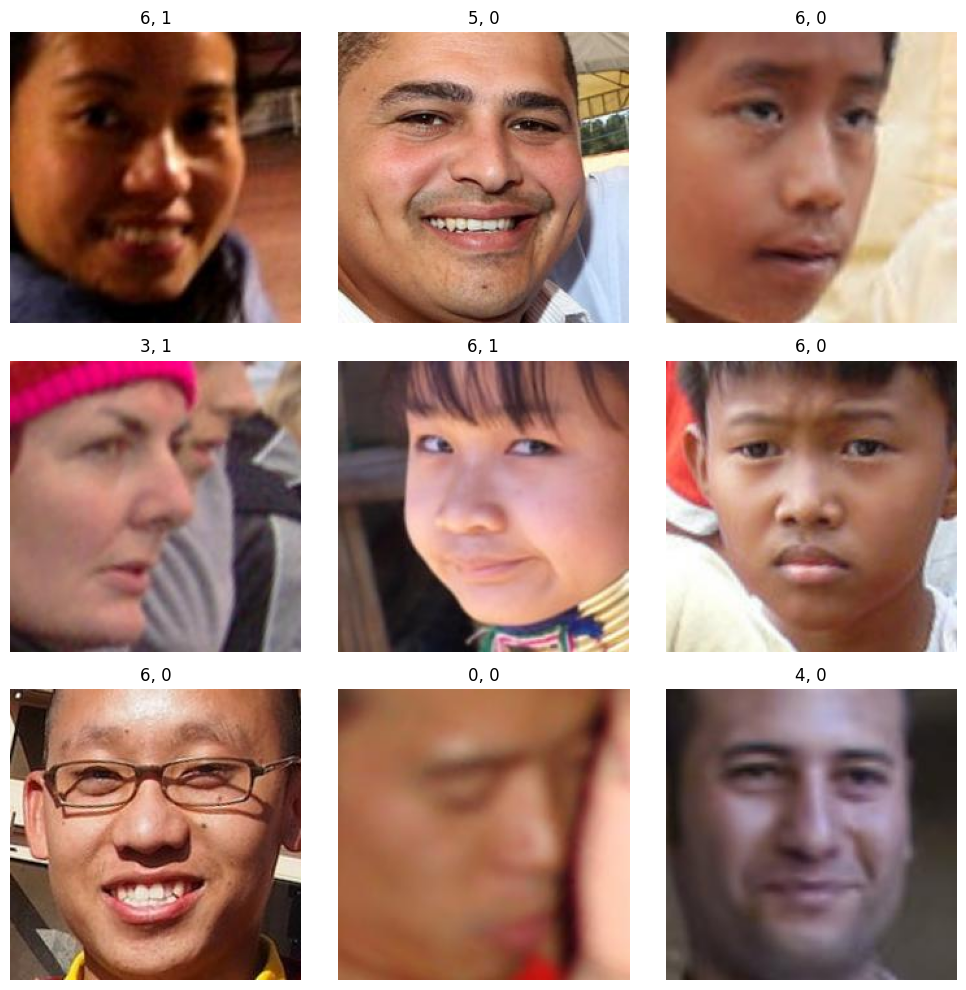

In [10]:
import matplotlib.pyplot as plt

def show_examples(dataset, n=9):
    sample = dataset["train"].shuffle(seed=42).select(range(n))
    plt.figure(figsize=(10,10))
    for i, ex in enumerate(sample):
        plt.subplot(3,3,i+1)
        plt.imshow(ex["image"])
        plt.axis("off")
        plt.title(f"{ex['race']}, {ex['gender']}")
    plt.tight_layout()
    plt.show()

show_examples(dataset)


### Observaciones iniciales

- El dataset está **desequilibrado**: algunas categorías raciales tienen muchas más muestras que otras (p. ej. "White" o "Black" predominan sobre "Southeast Asian").
- Los géneros están distribuidos aproximadamente 50/50, pero con ligeras diferencias según grupo racial.
- Estas diferencias de frecuencia pueden inducir **sesgos de representación** en modelos faciales si no se corrigen o equilibran.

A continuación crearemos subconjuntos de diferentes tamaños y balances (E1–E9) para estudiar su impacto en la equidad.


## 5. Creación de subconjuntos experimentales (E1–E9)

En esta sección generaremos subconjuntos del dataset FairFace con diferentes configuraciones de tamaño y balance de clases.

Los experimentos siguen la siguiente tabla:

| Experimento | Tamaño total  | Estrategia                      | Tamaño por combinación (≈)   | Nivel de ajuste |
| ----------- | ------------- | ------------------------------- | ---------------------------- | --------------- |
| E1          | 6,000         | Desbalance natural ajustado 1:5 | Variable según raza × género | Bajo            |
| E2          | 12,000        | Desbalance natural ajustado 1:5 | Variable                     | Medio           |
| E3          | 16,000        | Desbalance natural ajustado 1:5 | Variable                     | Alto            |
| E4          | 120 por clase | Few-shot ampliado               | 200 por grupo                | Bajo            |
| E5          | 200 por clase | Few-shot ampliado               | 400 por grupo                | Medio           |
| E6          | 300 por clase | Few-shot ampliado               | 800 por grupo                | Alto            |
| E7          | 6,000         | Data augmentation balanceada    | 6,000 / 14 ≈ 429             | Bajo            |
| E8          | 12,000        | Data augmentation balanceada    | 12,000 / 14 ≈ 857            | Medio           |
| E9          | 16,000        | Data augmentation balanceada    | 16,000 / 14 ≈ 1,143          | Alto            |

Estos subconjuntos se crearán a partir de la versión cargada de `FairFace` usando muestreos estratificados.


In [11]:
def create_unbalanced_subset(df, total_size, target_ratio=1/5, seed=42):
    """
    Crea un subset desbalanceado considerando race x gender, cumpliendo un ratio aproximado
    entre el grupo mayoritario y los demás grupos.
    
    - total_size: tamaño total del subset
    - target_ratio: n_minor / n_major
    """
    np.random.seed(seed)
    
    # Crear columna de grupo interseccional
    df = df.copy()
    df['group'] = df['race'].astype(str) + "_" + df['gender'].astype(str)
    
    groups = df['group'].unique()
    
    # Identificar grupo mayoritario natural
    group_counts = df['group'].value_counts()
    main_group = group_counts.idxmax()
    minor_groups = [g for g in groups if g != main_group]
    
    # Calcular n_major y n_minor por grupo
    n_minor_total_ratio = target_ratio * len(minor_groups)
    n_major = int(total_size / (1 + n_minor_total_ratio))
    n_minor = int(n_major * target_ratio)
    
    # Ajustar si no hay suficientes ejemplos
    n_major = min(n_major, len(df[df['group'] == main_group]))
    
    # Tomar ejemplos del grupo mayoritario
    df_major = df[df['group'] == main_group].sample(n=n_major, random_state=seed)
    
    # Tomar ejemplos de los grupos minoritarios
    df_minor_list = []
    for g in minor_groups:
        available = len(df[df['group'] == g])
        n_take = min(n_minor, available)
        df_minor_list.append(df[df['group'] == g].sample(n=n_take, random_state=seed))
    
    df_minor = pd.concat(df_minor_list)
    
    # Combinar y mezclar
    subset = pd.concat([df_major, df_minor]).sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Eliminar columna temporal
    subset = subset.drop(columns=['group'])
    
    return subset



def create_balanced_subset(df, n_per_group, seed=42):
    """
    Crea un subconjunto balanceado por combinación (race, gender) con n_per_group ejemplos por grupo.
    """
    np.random.seed(seed)
    subsets = []
    
    # Agrupamos por race y gender
    for (race, gender), group in df.groupby(['race','gender']):
        # Muestreo con reemplazo si no hay suficientes ejemplos
        samples = group.sample(n=n_per_group, replace=(len(group)<n_per_group), random_state=seed)
        subsets.append(samples)
    
    # Mezclamos todos los grupos
    return pd.concat(subsets).sample(frac=1, random_state=seed).reset_index(drop=True)



In [12]:
# Creamos los experimentos E1–E6 con tamaños ajustados
experiments = {}

# ------------------------
# E1–E3: desbalance natural ajustado 1:5
# ------------------------
experiments["E1"] = create_unbalanced_subset(df, total_size=6000, target_ratio=1/5)
experiments["E2"] = create_unbalanced_subset(df, total_size=12000, target_ratio=1/5)
experiments["E3"] = create_unbalanced_subset(df, total_size=16000, target_ratio=1/5)

# ------------------------
# E4–E6: few-shot ampliado
# ------------------------
experiments["E4"] = create_balanced_subset(df, n_per_group=200)  # few-shot bajo
experiments["E5"] = create_balanced_subset(df, n_per_group=400)  # few-shot medio
experiments["E6"] = create_balanced_subset(df, n_per_group=800)  # few-shot alto

# Imprimir resumen
for k, v in experiments.items():
    print(f"{k}: {len(v)} muestras ({v['race'].nunique()} razas, {v['gender'].nunique()} géneros)")



E1: 5995 muestras (7 razas, 2 géneros)
E2: 11991 muestras (7 razas, 2 géneros)
E3: 15988 muestras (7 razas, 2 géneros)
E4: 2800 muestras (7 razas, 2 géneros)
E5: 5600 muestras (7 razas, 2 géneros)
E6: 11200 muestras (7 razas, 2 géneros)


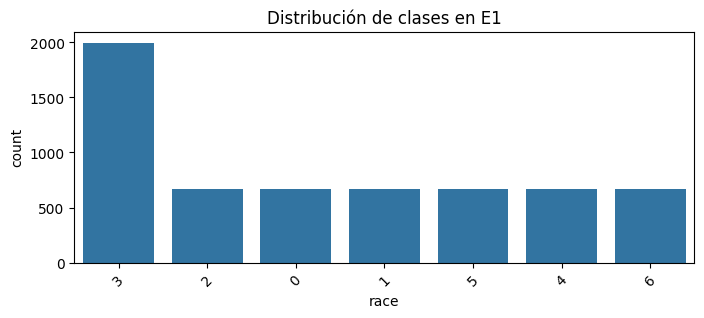

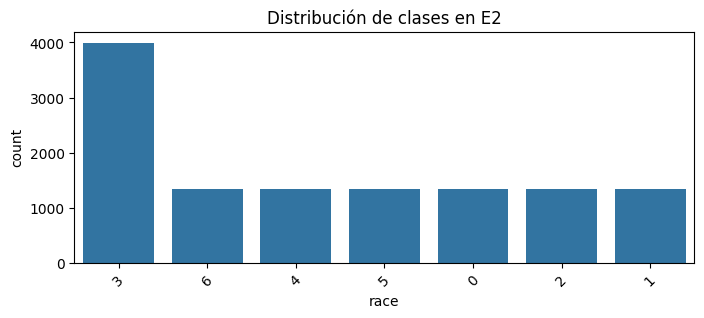

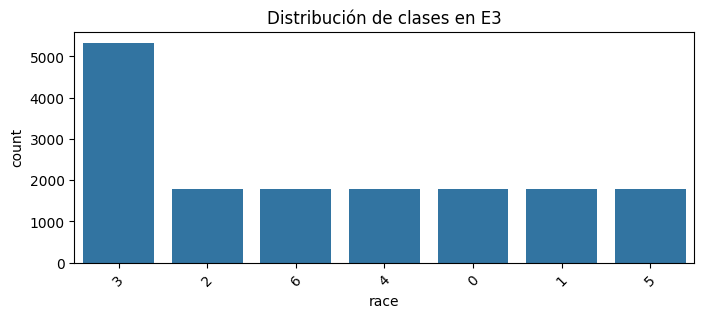

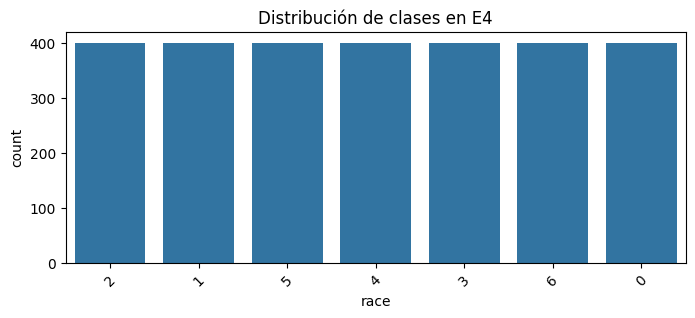

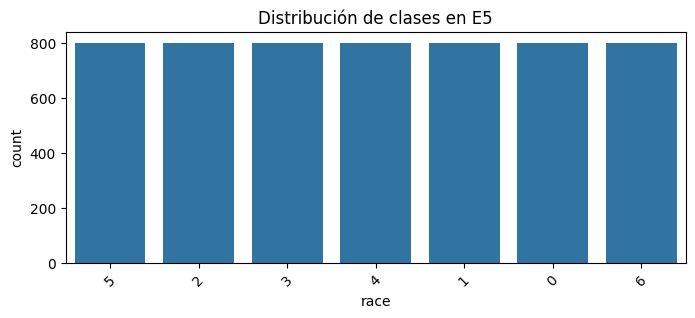

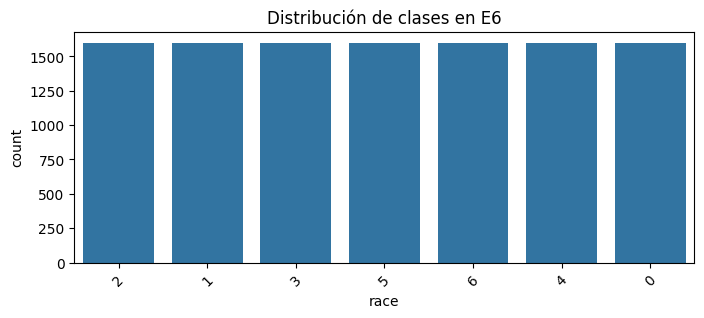

In [13]:
def plot_distribution(subset, title):
    plt.figure(figsize=(8,3))
    sns.countplot(data=subset, x="race", order=subset["race"].value_counts().index)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

for name, subset in experiments.items():
    plot_distribution(subset, f"Distribución de clases en {name}")


### Próximo paso

Los subconjuntos E1–E6 están listos.  
A continuación, generaremos las versiones E7–E9, donde se aplicará **data augmentation balanceado** para aumentar la diversidad y tamaño de los conjuntos, manteniendo la equidad entre clases.


## 6. Creación de subconjuntos E7–E9 con Data Augmentation

Para los experimentos E7–E9 queremos:
- Mantener **balance 1:1 por clase**.
- Aumentar el tamaño total mediante **data augmentation**.

Usaremos transformaciones básicas de `torchvision`:
- Rotaciones aleatorias
- Flip horizontal
- Cambio de brillo/contraste/saturación
- Recortes aleatorios

Estas augmentations simulan un conjunto más diverso y permiten evaluar si la equidad mejora al aumentar el tamaño de manera artificial.


In [14]:
# Transformaciones básicas
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224,224), scale=(0.8,1.0))
])
def augment(df_subset, dataset_hf, total_size, index_col="__index_level_0__", augment_fn=None, seed=42):
    """
    Rellena los grupos minoritarios (race x gender) mediante augmentations para que el dataset
    resultante tenga exactamente total_size y quede balanceado.
    
    df_subset: DataFrame inicial con columnas 'race', 'gender' y columna index_col
    dataset_hf: Dataset Hugging Face
    total_size: tamaño final deseado
    augment_fn: función que aplica augmentations a una imagen (PIL -> PIL)
    """
    if augment_fn is None:
        raise ValueError("Debe proporcionarse una función de augmentación")
    
    np.random.seed(seed)
    
    n_groups = df_subset.groupby(['race','gender']).ngroups
    n_per_group = total_size // n_groups  # tamaño deseado por grupo
    
    balanced_list = []
    
    for (race, gender), group in df_subset.groupby(['race','gender']):
        n_needed = n_per_group - len(group)
        
        # Si el grupo tiene más de lo necesario, muestrear sin reemplazo
        if n_needed < 0:
            sampled = group.sample(n=n_per_group, random_state=seed)
            balanced_list.append(sampled)
            continue
        
        # Empezamos con los originales
        balanced_list.append(group)
        
        # Si se necesitan más, aplicar augmentations con reemplazo
        if n_needed > 0:
            sampled_rows = group.sample(n=n_needed, replace=True, random_state=seed)
            augmented = []
            for _, row in sampled_rows.iterrows():
                img = dataset_hf["train"][row[index_col]]["image"]
                aug_img = augment_fn(img)
                augmented.append({
                    "image": aug_img,
                    "race": race,
                    "gender": gender,
                    "age": row["age"]
                })
            balanced_list.append(pd.DataFrame(augmented))
    
    # Combinar y mezclar
    final_df = pd.concat(balanced_list).sample(frac=1, random_state=seed).reset_index(drop=True)
    
    # Ajuste final si por división entera hay pequeñas diferencias
    if len(final_df) < total_size:
        deficit = total_size - len(final_df)
        extras = final_df.sample(n=deficit, replace=True, random_state=seed)
        final_df = pd.concat([final_df, extras]).sample(frac=1, random_state=seed).reset_index(drop=True)
    elif len(final_df) > total_size:
        final_df = final_df.sample(n=total_size, random_state=seed).reset_index(drop=True)
    
    return final_df


In [15]:
aug_configs = {
    "E7": 6000,
    "E8": 12000,
    "E9": 16000
}

experiments_aug = {}

for exp_name, total_size in aug_configs.items():
    df_exp = augment(df, dataset, total_size=total_size,
                                    index_col="__index_level_0__", augment_fn=augment_transform)
    experiments_aug[exp_name] = df_exp
    print(f"{exp_name}: {len(df_exp)} imágenes, "
          f"{len(df_exp.groupby(['race','gender']))} grupos balanceados")


E7: 6000 imágenes, 14 grupos balanceados
E8: 12000 imágenes, 14 grupos balanceados
E9: 16000 imágenes, 14 grupos balanceados


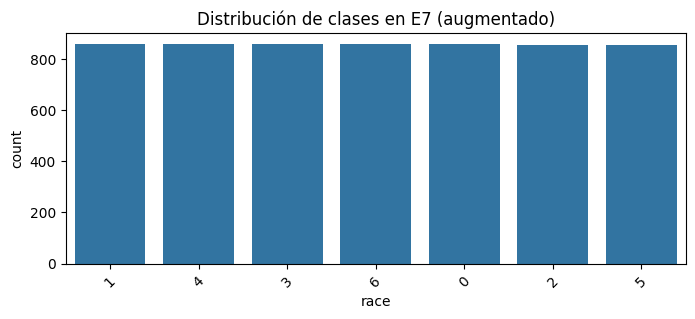

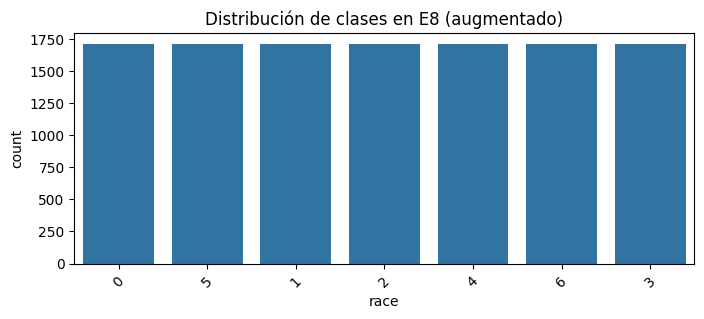

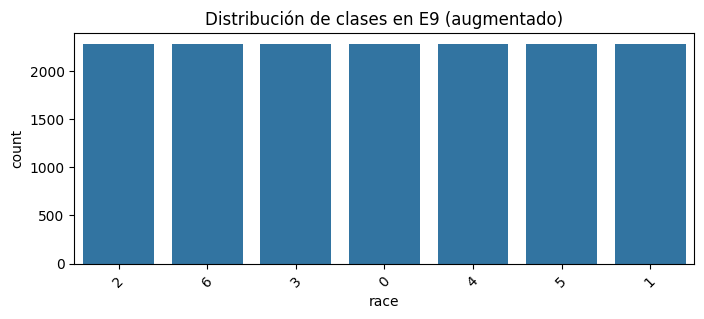

In [16]:
for name, subset in experiments_aug.items():
    plot_distribution(subset, f"Distribución de clases en {name} (augmentado)")

### Próximo paso

Con los subconjuntos E1–E9 ya creados (E1–E3 desbalanceados, E4–E6 balanceados, E7–E9 balanceados con augmentations) podemos pasar a:

1. Definir la **arquitectura del modelo preentrenado** (ResNet50, EfficientNet, etc.).
2. Preparar **DataLoaders** para entrenamiento y validación.
3. Entrenar los modelos para cada experimento y medir:
   - Métricas de rendimiento global (accuracy, F1-macro)
   - Métricas de equidad (demographic parity, equalized odds)


## 7. Preparar DataLoaders y modelo preentrenado

En esta sección definiremos:

1. **Transformaciones para entrenamiento y validación**
   - Entrenamiento: resize + augmentations básicas (si es E1–E6, opcional; E7–E9 ya tienen augmentations)
   - Validación: resize + center crop + normalización
2. **Dataset y DataLoader de PyTorch**
   - Usando los DataFrames generados (E1–E9)
3. **Modelo preentrenado**
   - ResNet50 de torchvision
   - Ajustamos la capa final (`fc`) según el número de clases raciales
4. **Funciones de entrenamiento y evaluación**


In [17]:
# Transformaciones
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Dataset PyTorch
class FairFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['image']
        if self.transform:
            img = self.transform(img)
        label = row['race']
        # Convertir a índice entero
        label = race_to_idx[label]
        return img, label

# Crear mapping de clase a índice
race_classes = df['race'].unique()
race_to_idx = {race:i for i,race in enumerate(race_classes)}
idx_to_race = {i:race for race,i in race_to_idx.items()}
n_classes = len(race_classes)
print("Clases:", race_to_idx)


Clases: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [18]:
def get_dataloaders(df_train, df_val=None, batch_size=32):
    train_dataset = FairFaceDataset(df_train, transform=train_transform)
    if df_val is not None:
        val_dataset = FairFaceDataset(df_val, transform=val_transform)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        val_loader = None
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)

def get_model(n_classes, full_finetune=True, device='cuda'):
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    if not full_finetune:
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    return model.to(device)

Usando dispositivo: cuda


In [20]:
def train_model(model, train_loader, val_loader=None, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        
        # Validación
        if val_loader:
            model.eval()
            preds, trues = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    predicted = torch.argmax(outputs, dim=1)
                    preds.extend(predicted.cpu().numpy())
                    trues.extend(labels.cpu().numpy())
            acc = accuracy_score(trues, preds)
            f1 = f1_score(trues, preds, average='macro')
            print(f"  Val Accuracy: {acc:.3f}, F1-macro: {f1:.3f}")
    return model


## 8. Entrenamiento de los experimentos E1–E9

En esta sección se entrenan los modelos para cada uno de los experimentos definidos previamente. La estrategia de entrenamiento depende de las características del subconjunto:

- **E1–E3:** Conjuntos desbalanceados y limitados → **fine-tuning completo** de ResNet50.  
- **E4–E6:** Conjuntos limitados pero balanceados → **few-shot / linear probe**, entrenando únicamente la capa final (`fc`) y congelando el resto del modelo.  
- **E7–E9:** Conjuntos balanceados mediante **data augmentation** → fine-tuning completo.

### Proceso por experimento:

1. Se crea un **modelo ResNet34 preentrenado**:
   - `full_finetune=True` → se actualizan todos los pesos (E1–E3, E7–E9).  
   - `full_finetune=False` → solo se entrena la capa final (`fc`) (E4–E6, few-shot).

2. Se preparan los **DataLoaders** usando los subconjuntos generados:
   - `train_loader` y `val_loader` apuntando al mismo subconjunto (por simplicidad en este bloque).  
   - Transformaciones: resize, normalización y augmentations si aplica.

3. Se ejecuta la función `train_model`:
   - Calcula la **loss** (CrossEntropyLoss) y actualiza los pesos según la estrategia.  
   - Muestra la **loss por epoch** y métricas de validación (`accuracy` y `F1-macro`) al final de cada epoch.

4. Se guardan:
   - **Modelos entrenados** en `trained_models` para cada experimento.  
   - **Resultados de evaluación** (`accuracy` y `F1-macro`) en `results_summary`.

### Objetivo:

- Evaluar cómo el **tamaño y balance del dataset** afecta la generalización del modelo.  
- Comparar **fine-tuning completo vs. few-shot**.  
- Tener todos los modelos listos para la **evaluación de equidad y análisis de sesgo**, siguiendo los objetivos del proyecto.


#### Test balanceado independiente

Creamos un **conjunto de test** balanceado por `(race, gender)` para evaluar todos los experimentos de forma consistente.  

- Definimos `n_per_group_test` ejemplos por grupo.  
- Usamos `create_balanced_subset` para seleccionar las muestras.  
- Convertimos a `FairFaceDataset` y `DataLoader`.

In [21]:
# -------------------------------
# 0️⃣ Crear test balanceado independiente
# -------------------------------

# Definir número de ejemplos por grupo (raza x género) que quieras para el test
n_per_group_test = 500

# Usar tu función de creación balanceada
df_test = create_balanced_subset(df_test, n_per_group=n_per_group_test)
test_dataset = FairFaceDataset(df_test, transform=val_transform)  # val_transform o test_transform
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test set: {len(df_test)} ejemplos, {len(df_test.groupby(['race','gender']))} grupos balanceados")


Test set: 7000 ejemplos, 14 grupos balanceados


In [22]:
# -------------------------------
# 0️⃣ Configuración inicial
# -------------------------------
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

trained_models = {}
results_summary = {}


# -------------------------------
# 2️⃣ Estrategia por experimento
# -------------------------------
experiment_strategy = {
    "E1": "full",
    "E2": "full",
    "E3": "full",
    "E4": "few-shot",
    "E5": "few-shot",
    "E6": "few-shot",
    "E7": "full",
    "E8": "full",
    "E9": "full"
}

# -------------------------------
# 3️⃣ Combinar todos los experimentos
# -------------------------------
all_experiments = {}
all_experiments.update(experiments)      # E1–E6
all_experiments.update(experiments_aug)  # E7–E9

# -------------------------------
# Experimentos E1–E3
# -------------------------------
subset_to_run = ["E1", "E2", "E3"]

for exp_name, df_subset in all_experiments.items():
    if exp_name not in subset_to_run:
        continue

    print(f"\n=== Entrenando {exp_name} ===")
    
    checkpoint_path = os.path.join(checkpoint_dir, f"{exp_name}.pt")
    results_path = os.path.join(checkpoint_dir, f"{exp_name}_results.pt")

    if os.path.exists(checkpoint_path):
        print(f"Checkpoint encontrado: {checkpoint_path}")
        model_exp = get_model(n_classes, full_finetune=(experiment_strategy[exp_name]=="full"))
        model_exp.load_state_dict(torch.load(checkpoint_path))
        trained_models[exp_name] = copy.deepcopy(model_exp)
        if os.path.exists(results_path):
            results_summary[exp_name] = torch.load(results_path)
            print(f"Resultados cargados: {results_summary[exp_name]}")
        continue

    # Crear modelo
    full_finetune = experiment_strategy[exp_name] == "full"
    model_exp = get_model(n_classes, full_finetune=full_finetune)

    # Subsample temporal para pruebas rápidas (puedes quitarlo más adelante)
    df_subset = df_subset.sample(n=min(len(df_subset), 1000), random_state=42)

    # DataLoaders
    train_loader, val_loader = get_dataloaders(df_subset, df_subset, batch_size=32)

    # Entrenar (1 época rápida)
    model_exp = train_model(model_exp, train_loader, val_loader, epochs=1, lr=1e-4)

    # Guardar
    torch.save(model_exp.state_dict(), checkpoint_path)

    # Evaluación sobre test balanceado
    model_exp.eval()
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_exp(imgs)
            predicted = torch.argmax(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    results_summary[exp_name] = {"accuracy": acc, "f1_macro": f1}
    print(f"{exp_name}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")





=== Entrenando E1 ===


Epoch 1/1, Loss: 1.8329
  Val Accuracy: 0.694, F1-macro: 0.646
E1: Accuracy=0.320, F1-macro=0.282

=== Entrenando E2 ===
Epoch 1/1, Loss: 1.8143
  Val Accuracy: 0.594, F1-macro: 0.511
E2: Accuracy=0.278, F1-macro=0.224

=== Entrenando E3 ===
Epoch 1/1, Loss: 1.7827
  Val Accuracy: 0.691, F1-macro: 0.652
E3: Accuracy=0.325, F1-macro=0.282


In [23]:
# -------------------------------
# Experimentos E4–E6
# -------------------------------
subset_to_run = ["E4", "E5", "E6"]

for exp_name, df_subset in all_experiments.items():
    if exp_name not in subset_to_run:
        continue

    print(f"\n=== Entrenando {exp_name} ===")
    
    checkpoint_path = os.path.join(checkpoint_dir, f"{exp_name}.pt")
    results_path = os.path.join(checkpoint_dir, f"{exp_name}_results.pt")

    if os.path.exists(checkpoint_path):
        print(f"Checkpoint encontrado: {checkpoint_path}")
        model_exp = get_model(n_classes, full_finetune=(experiment_strategy[exp_name]=="full"))
        model_exp.load_state_dict(torch.load(checkpoint_path))
        trained_models[exp_name] = copy.deepcopy(model_exp)
        if os.path.exists(results_path):
            results_summary[exp_name] = torch.load(results_path)
            print(f"Resultados cargados: {results_summary[exp_name]}")
        continue

    full_finetune = experiment_strategy[exp_name] == "full"
    model_exp = get_model(n_classes, full_finetune=full_finetune)

    train_loader, val_loader = get_dataloaders(df_subset, df_subset, batch_size=16)
    model_exp = train_model(model_exp, train_loader, val_loader, epochs=2, lr=1e-4)

    torch.save(model_exp.state_dict(), checkpoint_path)
    # Evaluación sobre test balanceado
    model_exp.eval()
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_exp(imgs)
            predicted = torch.argmax(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    results_summary[exp_name] = {"accuracy": acc, "f1_macro": f1}
    print(f"{exp_name}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")




=== Entrenando E4 ===
Epoch 1/2, Loss: 2.0316
  Val Accuracy: 0.163, F1-macro: 0.159
Epoch 2/2, Loss: 1.9742
  Val Accuracy: 0.192, F1-macro: 0.188
E4: Accuracy=0.177, F1-macro=0.172

=== Entrenando E5 ===
Epoch 1/2, Loss: 1.9649
  Val Accuracy: 0.212, F1-macro: 0.207
Epoch 2/2, Loss: 1.8867
  Val Accuracy: 0.257, F1-macro: 0.248
E5: Accuracy=0.236, F1-macro=0.228

=== Entrenando E6 ===
Epoch 1/2, Loss: 1.9535
  Val Accuracy: 0.227, F1-macro: 0.222
Epoch 2/2, Loss: 1.8484
  Val Accuracy: 0.284, F1-macro: 0.276
E6: Accuracy=0.262, F1-macro=0.255


In [24]:
# -------------------------------
# Experimentos E7–E9
# -------------------------------
subset_to_run = ["E7", "E8", "E9"]

for exp_name, df_subset in all_experiments.items():
    if exp_name not in subset_to_run:
        continue

    print(f"\n=== Entrenando {exp_name} ===")
    
    checkpoint_path = os.path.join(checkpoint_dir, f"{exp_name}.pt")
    results_path = os.path.join(checkpoint_dir, f"{exp_name}_results.pt")

    if os.path.exists(checkpoint_path):
        print(f"Checkpoint encontrado: {checkpoint_path}")
        model_exp = get_model(n_classes, full_finetune=(experiment_strategy[exp_name]=="full"))
        model_exp.load_state_dict(torch.load(checkpoint_path))
        trained_models[exp_name] = copy.deepcopy(model_exp)
        if os.path.exists(results_path):
            results_summary[exp_name] = torch.load(results_path)
            print(f"Resultados cargados: {results_summary[exp_name]}")
        continue

    model_exp = get_model(n_classes, full_finetune=True)

    df_subset = df_subset.sample(n=min(len(df_subset), 2000), random_state=42)
    train_loader, val_loader = get_dataloaders(df_subset, df_subset, batch_size=32)

    model_exp = train_model(model_exp, train_loader, val_loader, epochs=1, lr=1e-4)

    torch.save(model_exp.state_dict(), checkpoint_path)

    model_exp.eval()
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_exp(imgs)
            predicted = torch.argmax(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    results_summary[exp_name] = {"accuracy": acc, "f1_macro": f1}
    print(f"{exp_name}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")




=== Entrenando E7 ===
Epoch 1/1, Loss: 1.7289
  Val Accuracy: 0.607, F1-macro: 0.596
E7: Accuracy=0.396, F1-macro=0.379

=== Entrenando E8 ===
Epoch 1/1, Loss: 1.7234
  Val Accuracy: 0.655, F1-macro: 0.653
E8: Accuracy=0.399, F1-macro=0.389

=== Entrenando E9 ===
Epoch 1/1, Loss: 1.7151
  Val Accuracy: 0.606, F1-macro: 0.587
E9: Accuracy=0.413, F1-macro=0.389


In [25]:
# -------------------------------
# 4️⃣ Cargar checkpoints y preparar evaluación sobre test
# -------------------------------
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

trained_models = {}
results_summary = {}

for exp_name in all_experiments.keys():
    checkpoint_path = os.path.join(checkpoint_dir, f"{exp_name}.pt")
    results_path = os.path.join(checkpoint_dir, f"{exp_name}_results.pt")
    
    if os.path.exists(checkpoint_path):
        # Crear modelo según estrategia
        full_finetune = experiment_strategy[exp_name] == "full"
        model_exp = get_model(n_classes, full_finetune=full_finetune)
        
        # Cargar pesos
        model_exp.load_state_dict(torch.load(checkpoint_path))
        trained_models[exp_name] = model_exp
        
        # Evaluar sobre test
        model_exp.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model_exp(imgs)
                predicted = torch.argmax(outputs, dim=1)
                preds.extend(predicted.cpu().numpy())
                trues.extend(labels.cpu().numpy())
        acc = accuracy_score(trues, preds)
        f1 = f1_score(trues, preds, average='macro')
        results_summary[exp_name] = {"accuracy": acc, "f1_macro": f1}
        
        # Guardar resultados
        torch.save(results_summary[exp_name], results_path)
        
        print(f"{exp_name} cargado. Test Accuracy={acc:.3f}, F1-macro={f1:.3f}")
    else:
        print(f"Checkpoint no encontrado para {exp_name}, será necesario entrenarlo.")


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E1 cargado. Test Accuracy=0.320, F1-macro=0.282


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E2 cargado. Test Accuracy=0.278, F1-macro=0.224


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E3 cargado. Test Accuracy=0.325, F1-macro=0.282


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E4 cargado. Test Accuracy=0.177, F1-macro=0.172


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E5 cargado. Test Accuracy=0.236, F1-macro=0.228


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E6 cargado. Test Accuracy=0.262, F1-macro=0.255


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E7 cargado. Test Accuracy=0.396, F1-macro=0.379


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E8 cargado. Test Accuracy=0.399, F1-macro=0.389


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\1399525083.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_exp.load_state_dict(torch.load(checkpoint_path))


E9 cargado. Test Accuracy=0.413, F1-macro=0.389


## 9. Evaluación y visualización de resultados

En esta sección compararemos los resultados de los experimentos E1–E9:

- **Métricas globales**: Accuracy y F1-macro.  
- **Equidad**: desempeño por grupo racial.  
- **Comparación visual**: gráficos de barras y boxplots para observar cómo el tamaño, balance y augmentations afectan rendimiento y sesgo.

Esto nos permitirá analizar el impacto de:  
- Conjuntos limitados y desbalanceados (E1–E3)  
- Few-shot (E4–E6)  
- Data augmentation equilibrada (E7–E9)


In [26]:
# Crear un DataFrame con resultados globales
results_df = pd.DataFrame.from_dict(results_summary, orient='index')
results_df = results_df.reset_index().rename(columns={'index':'Experiment'})
results_df

,Experiment,accuracy,f1_macro
0,E1,0.320286,0.282130
1,E2,0.278429,0.223967
2,E3,0.324857,0.281863
3,E4,0.176857,0.172217
4,E5,0.235857,0.227636
5,E6,0.262429,0.255393
6,E7,0.396143,0.379373
7,E8,0.399000,0.389446
8,E9,0.412714,0.389267


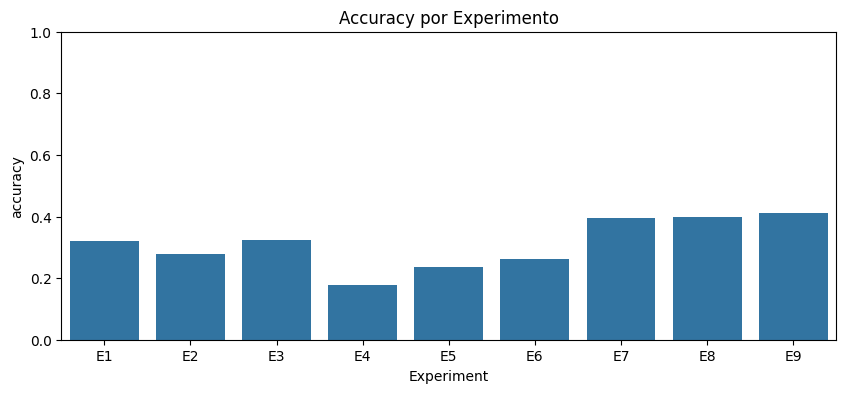

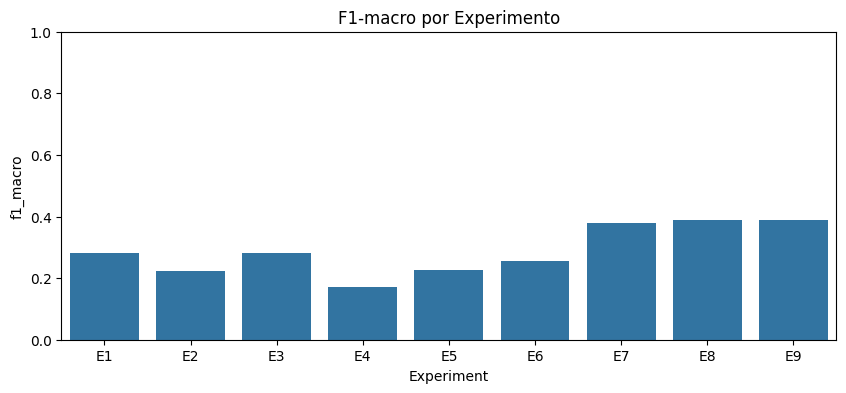

In [27]:
plt.figure(figsize=(10,4))
sns.barplot(x='Experiment', y='accuracy', data=results_df)
plt.title("Accuracy por Experimento")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='Experiment', y='f1_macro', data=results_df)
plt.title("F1-macro por Experimento")
plt.ylim(0,1)
plt.show()


In [28]:
# Función para calcular métricas por raza
def metrics_by_race(model, df_subset):
    model.eval()
    preds, trues, races = [], [], []
    with torch.no_grad():
        for imgs, labels in DataLoader(FairFaceDataset(df_subset, transform=val_transform), batch_size=32):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            predicted = torch.argmax(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
            races.extend([idx_to_race[i] for i in labels.cpu().numpy()])
    df_metrics = pd.DataFrame({'race': races, 'true': trues, 'pred': preds})
    grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({
        'accuracy': accuracy_score(x['true'], x['pred']),
        'f1_macro': f1_score(x['true'], x['pred'], average='macro')
    })).reset_index()
    return grouped



=== Métricas por raza para E1 ===
   race  accuracy  f1_macro
0     0  0.462462  0.090349
1     1  0.253754  0.057827
2     2  0.680180  0.115664
3     3  0.769885  0.124283
4     4  0.142643  0.035667
5     5  0.130631  0.033011
6     6  0.312312  0.067996


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


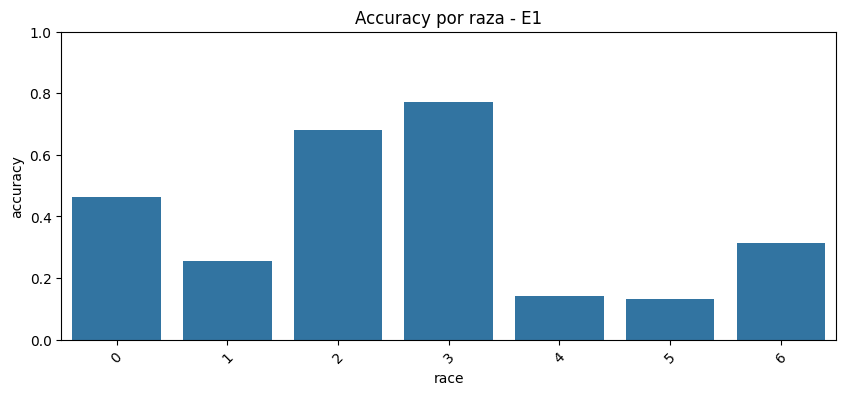


=== Métricas por raza para E2 ===
   race  accuracy  f1_macro
0     0  0.162162  0.039867
1     1  0.054805  0.014845
2     2  0.433934  0.086462
3     3  0.879220  0.133676
4     4  0.017267  0.004850
5     5  0.093844  0.024512
6     6  0.497748  0.094952


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


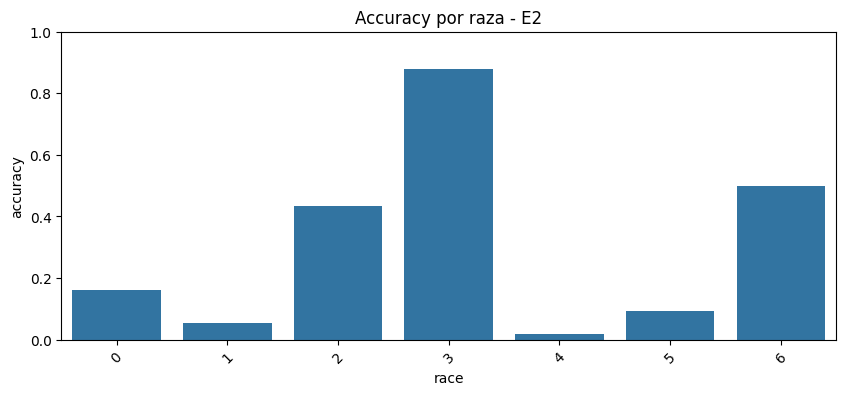


=== Métricas por raza para E3 ===
   race  accuracy  f1_macro
0     0  0.190315  0.045682
1     1  0.164977  0.040461
2     2  0.685248  0.116176
3     3  0.825019  0.129160
4     4  0.121059  0.030853
5     5  0.118243  0.030211
6     6  0.298986  0.065763


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


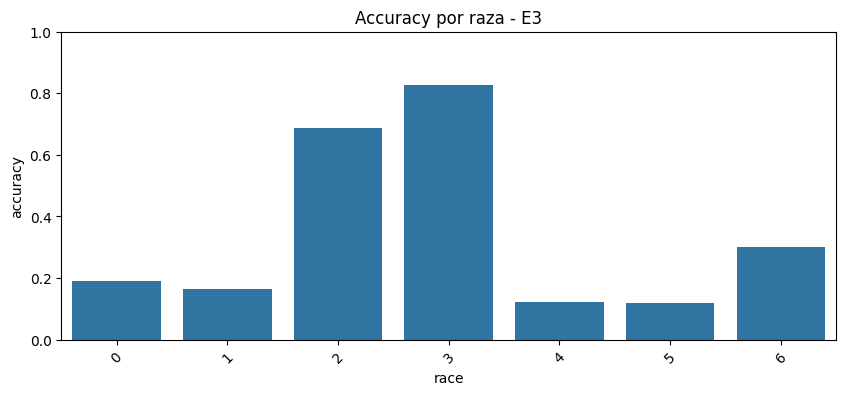


=== Métricas por raza para E4 ===
   race  accuracy  f1_macro
0     0    0.2325  0.053897
1     1    0.2850  0.063369
2     2    0.2800  0.062500
3     3    0.1150  0.029468
4     4    0.1250  0.031746
5     5    0.1475  0.036726
6     6    0.1575  0.038877


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


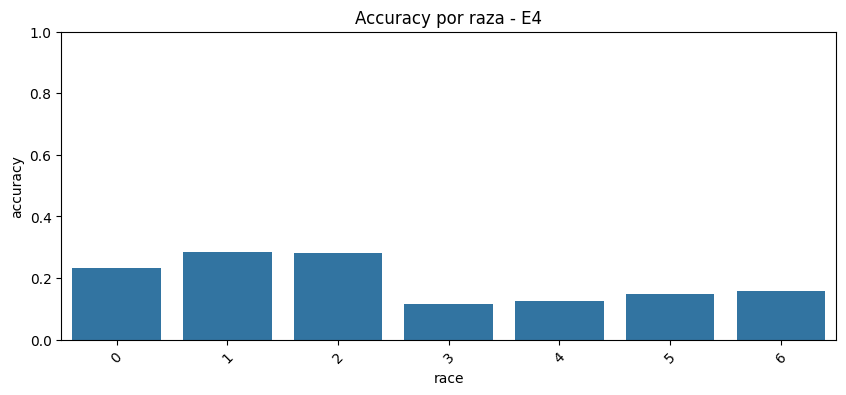


=== Métricas por raza para E5 ===
   race  accuracy  f1_macro
0     0   0.40625  0.082540
1     1   0.34000  0.072495
2     2   0.35250  0.074465
3     3   0.28875  0.064016
4     4   0.18000  0.043584
5     5   0.10000  0.025974
6     6   0.13250  0.033428


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


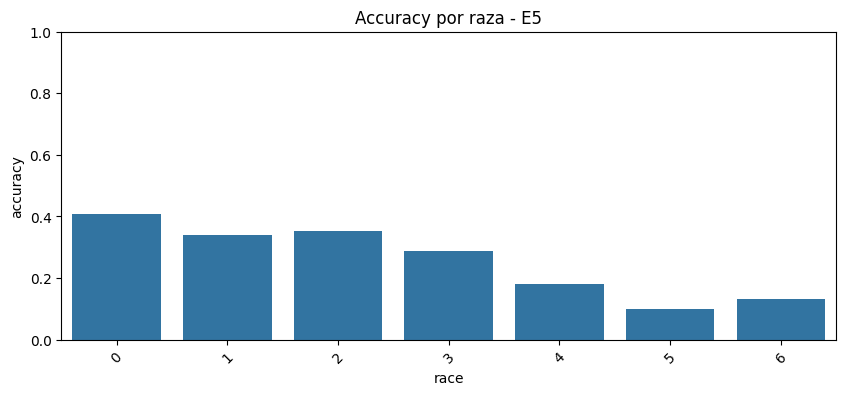


=== Métricas por raza para E6 ===
   race  accuracy  f1_macro
0     0  0.469375  0.091268
1     1  0.332500  0.071295
2     2  0.376250  0.078111
3     3  0.214375  0.050437
4     4  0.229375  0.053308
5     5  0.088125  0.023139
6     6  0.278750  0.062282


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


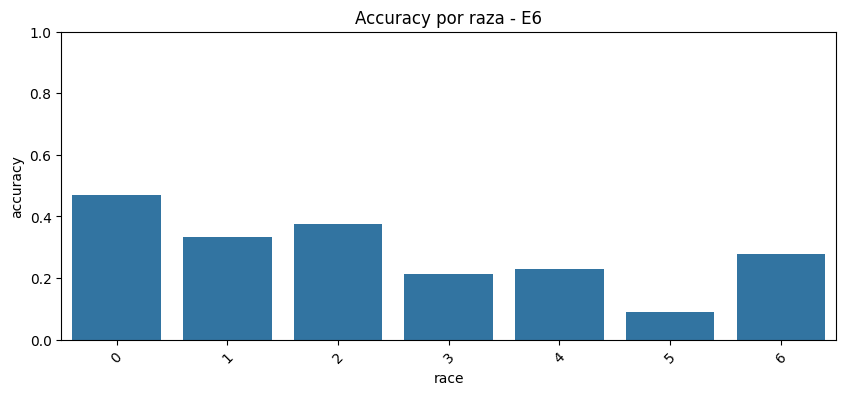


=== Métricas por raza para E7 ===
   race  accuracy  f1_macro
0     0  0.502917  0.095608
1     1  0.629070  0.110329
2     2  0.517523  0.097438
3     3  0.758460  0.123234
4     4  0.339557  0.072424
5     5  0.135514  0.034098
6     6  0.308051  0.067287


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


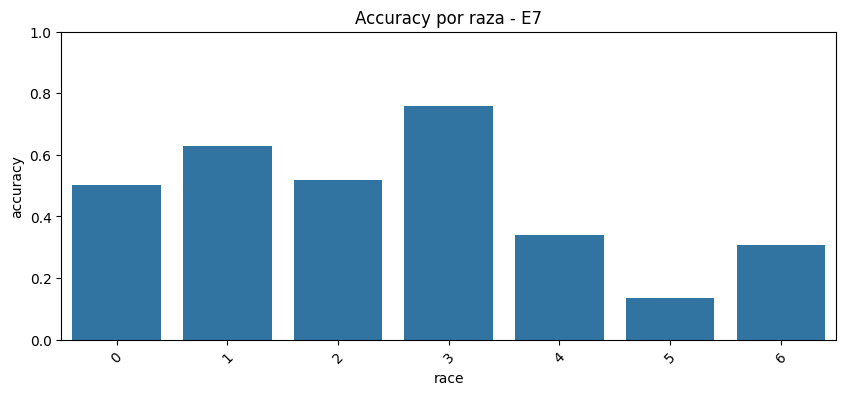


=== Métricas por raza para E8 ===
   race  accuracy  f1_macro
0     0  0.510204  0.096525
1     1  0.336056  0.071865
2     2  0.770128  0.124305
3     3  0.308635  0.067384
4     4  0.351225  0.074266
5     5  0.323615  0.069855
6     6  0.467911  0.091074


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


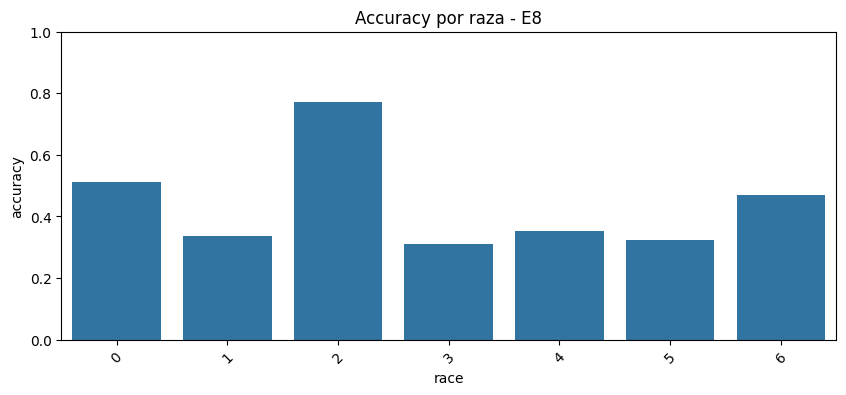


=== Métricas por raza para E9 ===
   race  accuracy  f1_macro
0     0  0.589239  0.105934
1     1  0.516200  0.097273
2     2  0.728584  0.120426
3     3  0.321522  0.069513
4     4  0.488626  0.093783
5     5  0.103765  0.026860
6     6  0.236220  0.054595


C:\Users\saulr\AppData\Local\Temp\ipykernel_2424\3269838898.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_metrics.groupby('race').apply(lambda x: pd.Series({


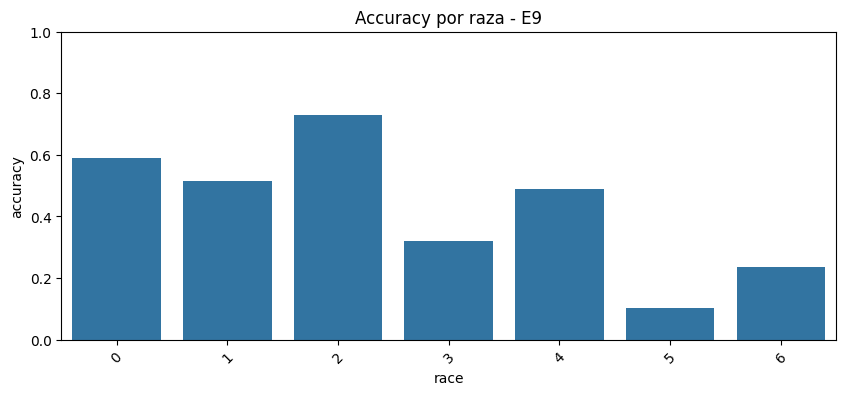

In [29]:
for exp_name, model in trained_models.items():
    print(f"\n=== Métricas por raza para {exp_name} ===")
    df_subset = all_experiments[exp_name]
    metrics_race = metrics_by_race(model, df_subset)
    print(metrics_race)
    
    # Gráfico
    plt.figure(figsize=(10,4))
    sns.barplot(x='race', y='accuracy', data=metrics_race)
    plt.title(f"Accuracy por raza - {exp_name}")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.show()


## 9️. Conclusiones

### Grupo 1 — Experimentos E1–E3 (Desbalanceados)
- **Objetivo:** Evaluar el rendimiento de modelos entrenados con datos desbalanceados, reproduciendo la distribución natural del conjunto original.
- **Resultados:**
  - Accuracy medio ≈ **0.31**
  - F1-macro medio ≈ **0.26**
- **Interpretación:**
  - A medida que aumenta el tamaño del conjunto de entrenamiento (de E1 a E3), se observa una mejora leve y progresiva en las métricas globales (accuracy y F1-macro).
Sin embargo, este incremento no se traduce en una mejora equitativa entre razas: las clases mayoritarias (raza 3, blanca) concentran la ganancia, mientras que las minoritarias apenas varían. Esto sugiere que el modelo aprovecha el mayor volumen de datos para reforzar patrones dominantes —aprende mejor a distinguir a las personas blancas—, pero no amplía su capacidad de generalización hacia razas infrarrepresentadas.
En otras palabras, más datos no significan menos sesgo, sino un refinamiento del sesgo existente cuando el dataset sigue desbalanceado.
  - Se aprecia la existencia de una especie de “techo de rendimiento” en las métricas.
Esto ocurre porque, al evaluar el modelo sobre un conjunto de test balanceado, el modelo tiende a reconocer con alta precisión la clase mayoritaria (la más representada durante el entrenamiento), pero falla con frecuencia en las clases minoritarias.
En otras palabras, aunque el modelo logra mantener una buena precisión global (accuracy), su desempeño real está limitado por el sesgo aprendido: prioriza la clase desbalanceada y no generaliza adecuadamente a las demás, lo que impide que las métricas de F1 o fairness mejoren más allá de cierto punto.
  - Se observa en las gráficas que el modelo tiende a comportarse como un discriminador entre las razas 2 y 3, mostrando una fuerte preferencia por estas clases y clasificando con menor frecuencia las demás.
Teniendo en cuenta que la raza 3 corresponde a personas blancas y la raza 2 a personas negras, se evidencia un sesgo significativo: el modelo sobreentrena la clase blanca, logrando identificar con facilidad cuándo una persona no pertenece a esta categoría, pero agrupando erróneamente al resto de razas entre sí.
La única excepción parcial es la raza 6 (asiática), que presenta un comportamiento algo distinto, lo que refuerza aún más el sesgo: el modelo parece “entender” las diferencias más marcadas, pero tiende a asociar indebidamente otras razas (como la india) con la clase negra, reflejando una generalización inadecuada y un sesgo racial evidente.



### Grupo 2 — Experimentos E4–E6 (Few-shot balanceados)
- **Objetivo:** Evaluar el impacto de entrenar con conjuntos **balanceados pero pequeños**, simulando escenarios de datos limitados.
- **Resultados:**
  - Accuracy medio ≈ **0.22**
  - F1-macro medio ≈ **0.22**
  - Se observa una mejora progresiva entre E4→E6 al aumentar `n_per_group`.
- **Interpretación:**
  - En los experimentos few-shot balanceados (E4–E6) se observa un crecimiento constante en las métricas de accuracy y F1-macro a medida que aumenta el número de ejemplos por grupo. Aunque los valores absolutos aún son moderados, esta tendencia indica que el modelo se beneficia directamente de disponer de más ejemplos balanceados, incluso cuando el total de datos sigue siendo relativamente pequeño. El comportamiento sugiere que, en contextos de sesgo interseccional, la calidad de la distribución de los datos pesa más que la cantidad total de ejemplos. Aun así, el aumento progresivo de rendimiento con datasets más grandes muestra que la estrategia óptima sería utilizar el mayor conjunto posible manteniendo el equilibrio entre razas y géneros, ya que esto permite mejorar la generalización sin reforzar los sesgos de clase mayoritaria.

  - Aunque los datasets de E4, E5 y E6 están totalmente balanceados por raza y género, se observan diferencias claras en accuracy y F1-macro entre clases:
      - Clases más fáciles de aprender: Algunas razas (por ejemplo la 0 y 2) alcanzan un accuracy relativamente alto incluso con pocos ejemplos. Esto indica que las características visuales de estas clases son más distintivas y fáciles de capturar por el modelo.

      - Clases más difíciles: Otras razas (como la 5 y 6) mantienen métricas bajas a pesar de estar representadas con el mismo número de ejemplos. Esto refleja que la dificultad intrínseca de la clase, la variabilidad dentro de sus imágenes o la similitud con otras clases hace que el modelo cometa más errores.

      - Diferencia entre accuracy y F1-macro: El accuracy puede verse inflado si el modelo acierta con frecuencia en algunas clases “fáciles”, mientras que el F1-macro, que pondera por clase, permanece bajo si hay muchas clases con predicciones incorrectas. Por ello, F1-macro es más sensible a la capacidad del modelo de tratar todas las clases por igual, incluso cuando el dataset está balanceado.



### Grupo 3 — Experimentos E7–E9 (Balanceados vía *Data Augmentation*)

**Objetivo:**  
Evaluar cómo el *data augmentation* ayuda a equilibrar las clases y mejorar el rendimiento en conjuntos originalmente desbalanceados.

**Resultados:**  
- Accuracy medio ≈ **0.40–0.41**  
- F1-macro medio ≈ **0.38–0.39**  
- Mejora notable respecto a E1–E3 (full train sin balance) y E4–E6 (few-shot balanceado).

**Interpretación:**  
- El *data augmentation* expone al modelo a más variaciones de cada clase, lo que incrementa su capacidad de generalización y mejora la representatividad de las clases minoritarias.  
- A pesar del aumento de datos, algunas clases todavía presentan métricas más bajas, lo que evidencia que el *augmentation* reduce pero no elimina por completo las disparidades de aprendizaje entre clases.  
- La tendencia observada, donde las métricas mejoran al incrementar el tamaño de los datasets balanceados, indica que **la estrategia más efectiva para maximizar F1-macro y accuracy es utilizar conjuntos balanceados lo más grandes posible**, combinando muestreo y *augmentation* cuando sea necesario.  



### Comparativa general

| Grupo | Experimentos | Dataset | Estrategia | Accuracy (≈) | F1-macro (≈) | Observación clave |
|:------|:--------------|:----------|:-------------|:---------------|:----------------|:--------------------|
| 1 | E1–E3 | Desbalanceado | Fine-tuning completo | 0.31 | 0.26 | Sesgo hacia clases mayoritarias |
| 2 | E4–E6 | Balanceado (few-shot) | Fine-tuning parcial | 0.22 | 0.22 | Equitativo pero con baja capacidad general |
| 3 | E7–E9 | Augmentado | Fine-tuning completo | 0.40 | 0.39 | Mejor equilibrio entre rendimiento y equidad |



### Conclusión general
- Los experimentos muestran que **el desbalance de datos favorece la precisión global** para las clases mayoritarias, pero penaliza notablemente la equidad entre grupos minoritarios.  
- Los modelos entrenados con **datasets balanceados pequeños** (few-shot) mejoran la representación y el rendimiento relativo de las clases minoritarias, pero su capacidad predictiva general sigue siendo limitada.  
- El uso de **data augmentation balanceado** (E7–E9) permite que el modelo vea más variaciones de cada clase, aumentando la generalización y mejorando tanto **accuracy** como **F1-macro**, aunque algunas clases aún presentan métricas más bajas.  
- La tendencia creciente en las métricas con el tamaño de los datasets sugiere que **usar conjuntos balanceados más grandes es clave para maximizar F1-macro y accuracy**.  
- En conjunto, **el augmentation balanceado emerge como la estrategia más efectiva y escalable**, combinando diversidad de datos, mitigación de sesgos y rendimiento general, sin depender únicamente de más datos reales.

